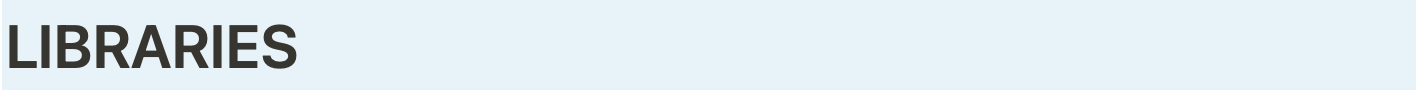

In [65]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout, Activation
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.15.0


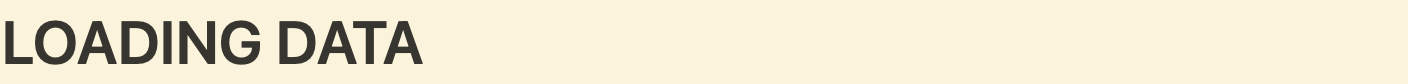

In [66]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = r'C:/Users/gk812/Desktop/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = r'C:/Users/gk812/Desktop/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:04<00:00, 180.70it/s]


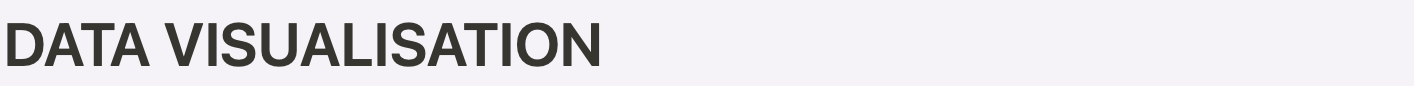

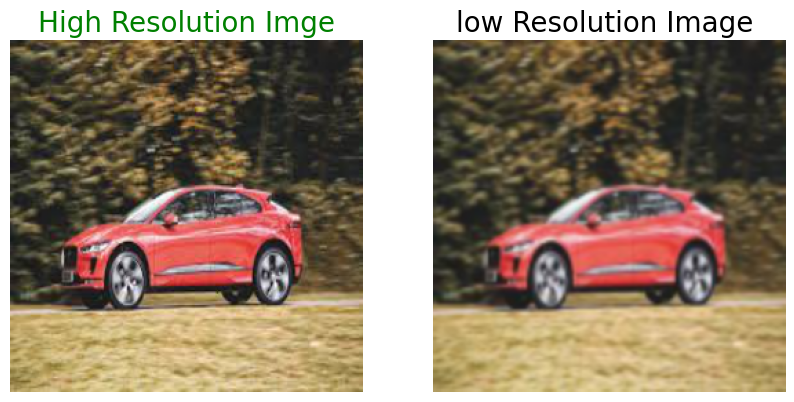

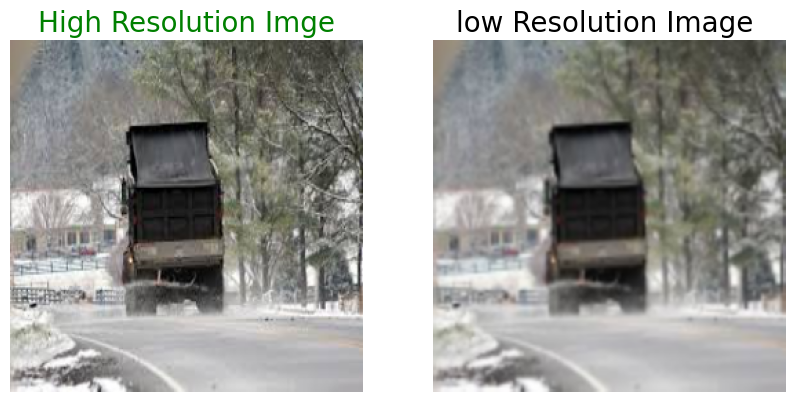

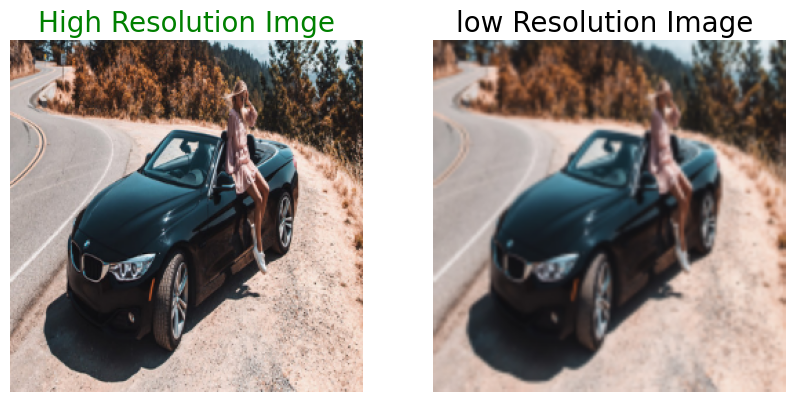

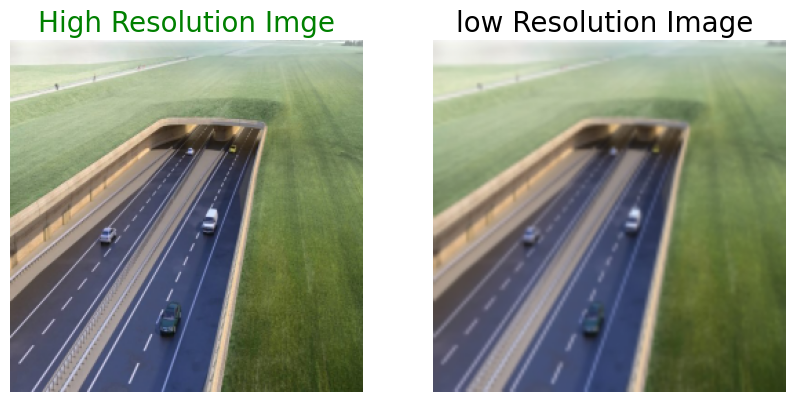

In [67]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

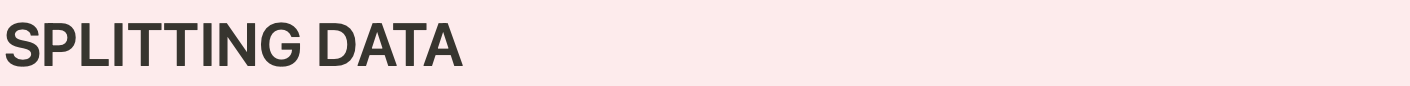

In [68]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# MODEL BUILDING 

In [69]:
input_img=Input(shape=(256,256,3))
l1=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu') (input_img)
l2=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(l1)
l3 = tf.keras.layers.Attention()([l1,l2])
#l3=tf.keras.layers.GlobalAveragePooling2D() (l3)
l4=tf.keras.layers.Dense(32, activation='relu')(l3)
l5=tf.keras.layers.Dense(64, activation='relu') (l4)
l6=Activation('softmax')(l5)
l7=tf.keras.layers.Conv2D(3,9,padding='same',activation='relu') (l6)


# l5=tf.keras.layers.AdditiveAttention()


Attention_based=Model(input_img,l7)


In [70]:
def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )

In [72]:
Attention_based.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = pixel_mse_loss,
              metrics = ['acc'])
Attention_based.summary()
plot_model(Attention_based, to_file ='super_res.png',show_shapes=True)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 256, 256, 128)        3584      ['input_23[0][0]']            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 256, 256, 128)        147584    ['conv2d_66[0][0]']           
                                                                                                  
 attention_22 (Attention)    (None, 256, 256, 128)        0         ['conv2d_66[0][0]',           
                                                                     'conv2d_67[0][0]']    

In [73]:
Attention_based.fit(train_low_image, train_high_image, epochs = 50, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/50
700/700 [==============================] - 895s 1s/step - loss: 0.0301 - acc: 0.4262 - val_loss: 0.0145 - val_acc: 0.5940
Epoch 2/50
700/700 [==============================] - 1424s 2s/step - loss: 0.0095 - acc: 0.5609 - val_loss: 0.0079 - val_acc: 0.6727
Epoch 3/50
700/700 [==============================] - 1714s 2s/step - loss: 0.0066 - acc: 0.5829 - val_loss: 0.0072 - val_acc: 0.5694
Epoch 4/50
700/700 [==============================] - 950s 1s/step - loss: 0.0061 - acc: 0.5806 - val_loss: 0.0131 - val_acc: 0.5083
Epoch 5/50
700/700 [==============================] - 562s 803ms/step - loss: 0.0059 - acc: 0.5888 - val_loss: 0.0063 - val_acc: 0.5380
Epoch 6/50
700/700 [==============================] - 628s 897ms/step - loss: 0.0051 - acc: 0.5834 - val_loss: 0.0058 - val_acc: 0.7444
Epoch 7/50
700/700 [==============================] - 627s 895ms/step - loss: 0.0049 - acc: 0.5957 - val_loss: 0.0043 - val_acc: 0.7112
Epoch 8/50
700/700 [==============================] - 1248

In [74]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2)

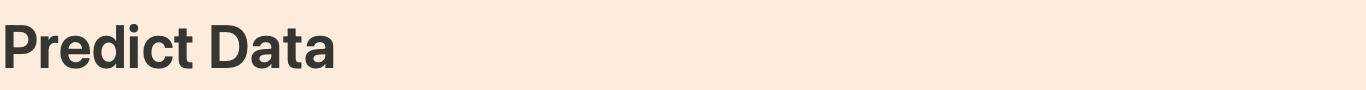

1/1 [==============================] - 1s 581ms/step


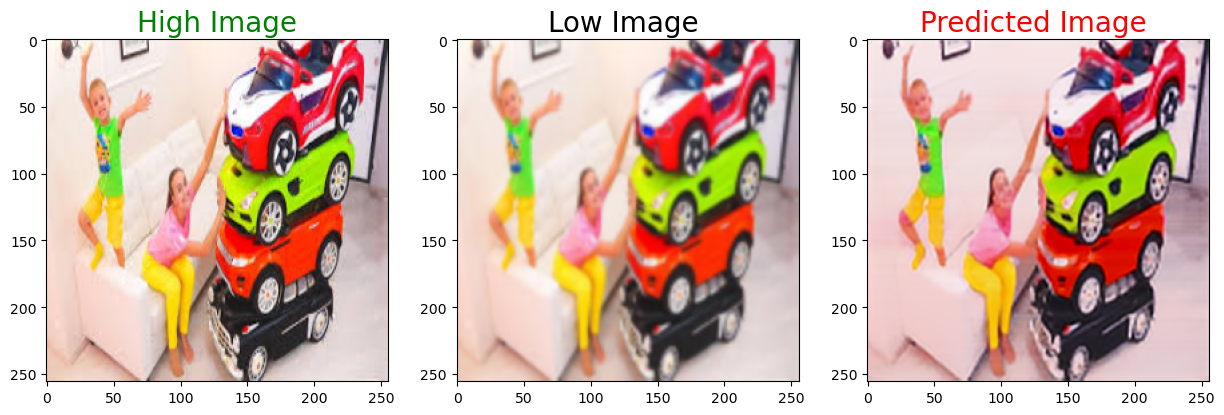

PSNR tf.Tensor(24.528175, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 212ms/step


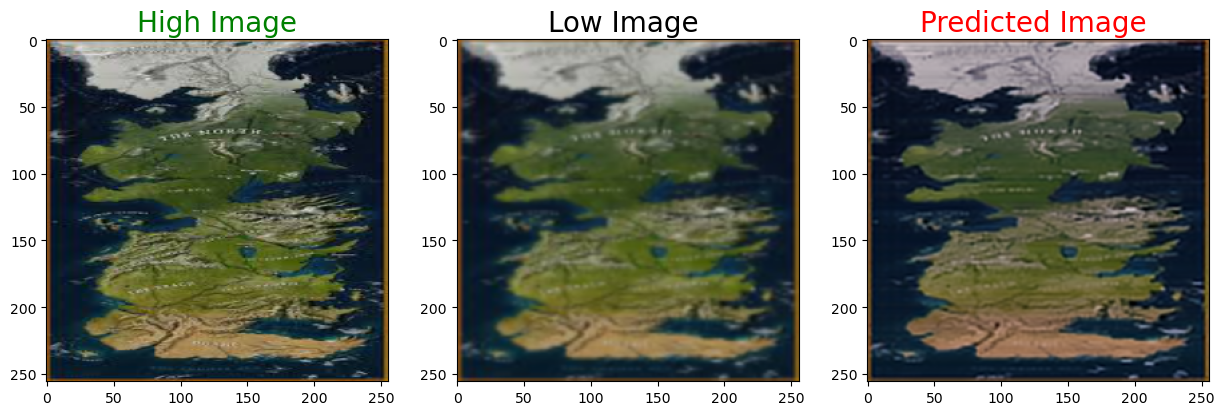

PSNR tf.Tensor(26.237377, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 216ms/step


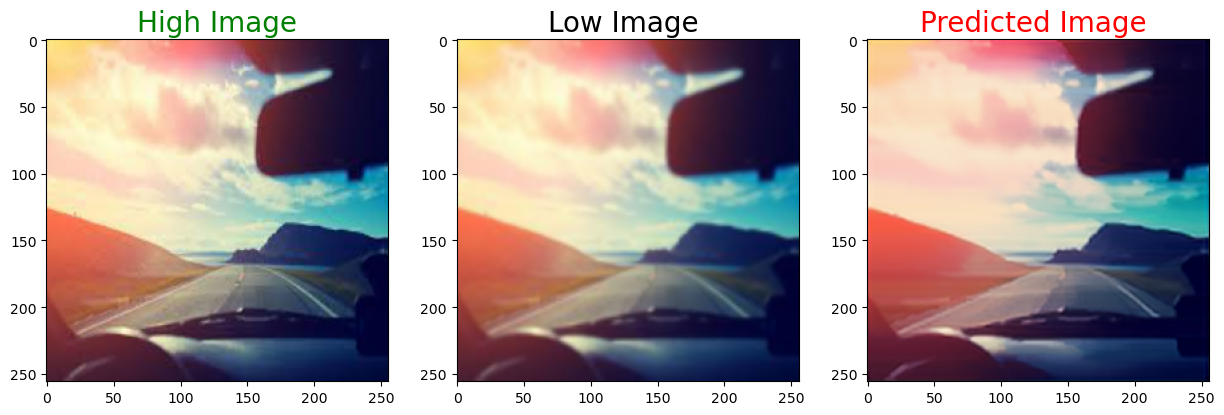

PSNR tf.Tensor(28.974646, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 270ms/step


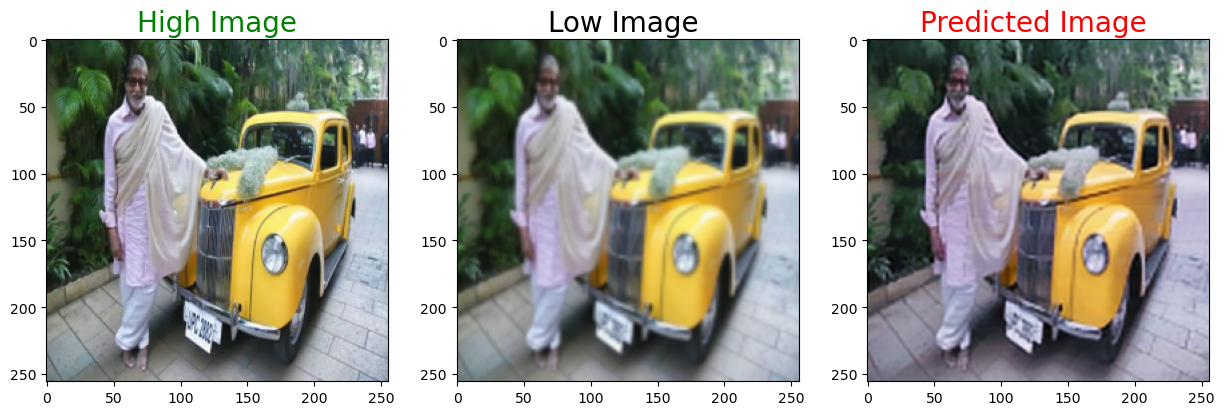

PSNR tf.Tensor(25.641613, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 228ms/step


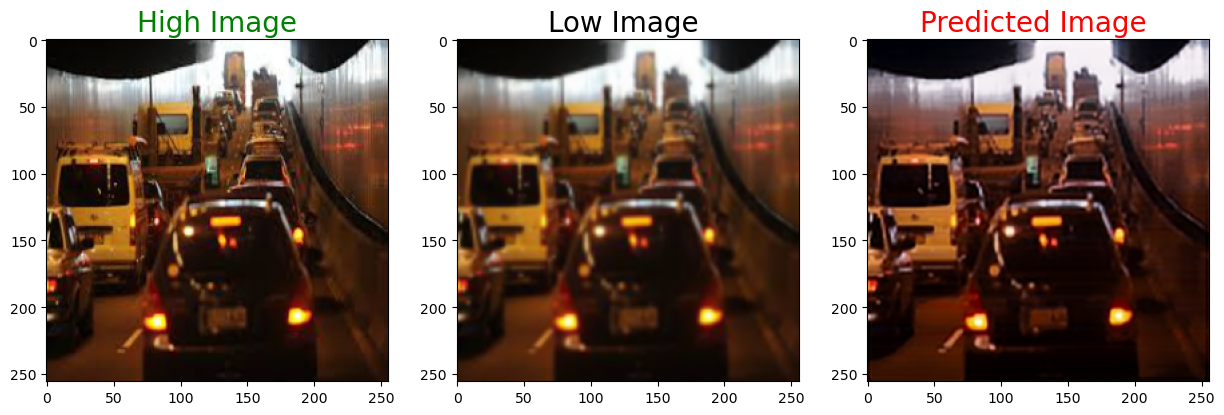

PSNR tf.Tensor(26.628073, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 230ms/step


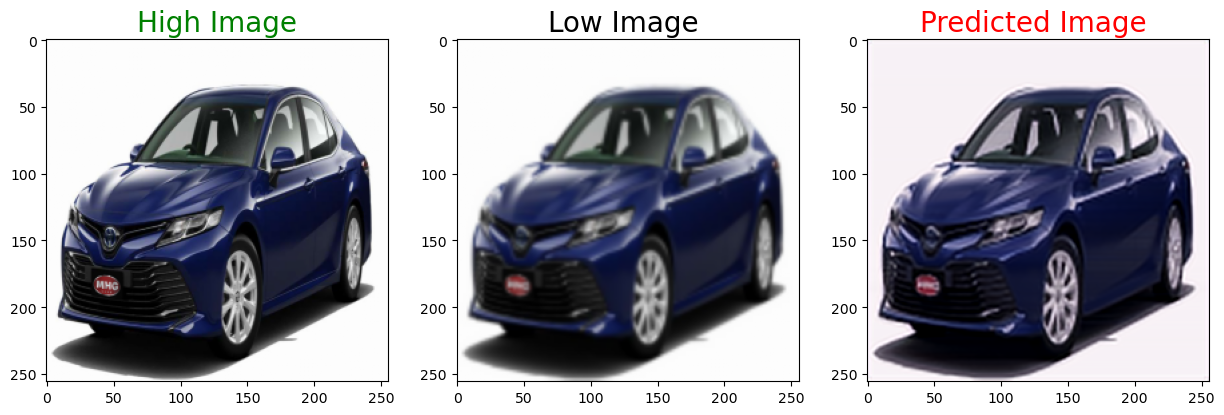

PSNR tf.Tensor(26.705853, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 243ms/step


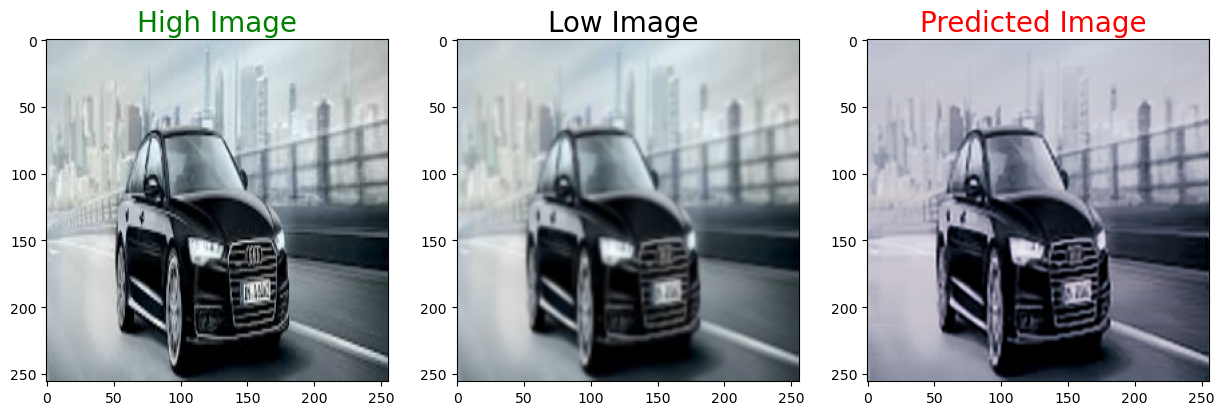

PSNR tf.Tensor(26.217106, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 262ms/step


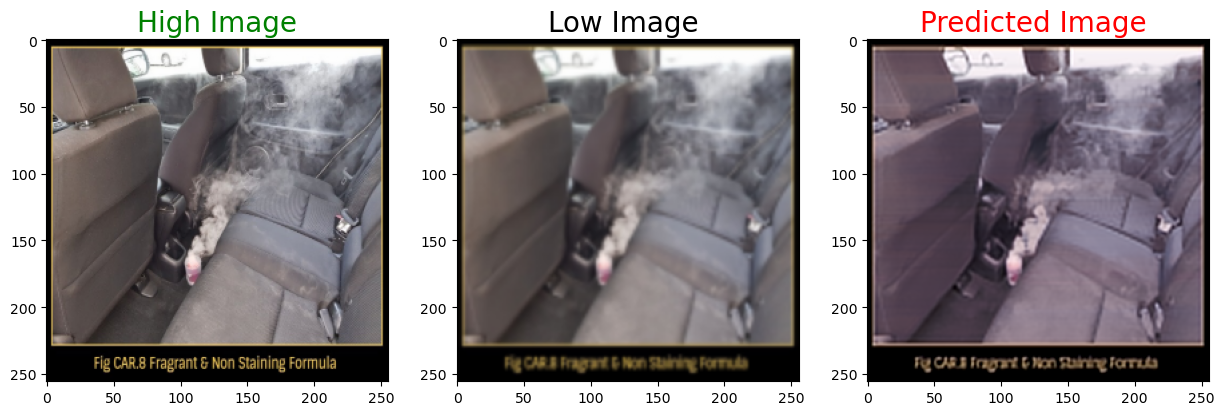

PSNR tf.Tensor(24.799389, shape=(), dtype=float32) dB
1/1 [==============================] - 0s 207ms/step


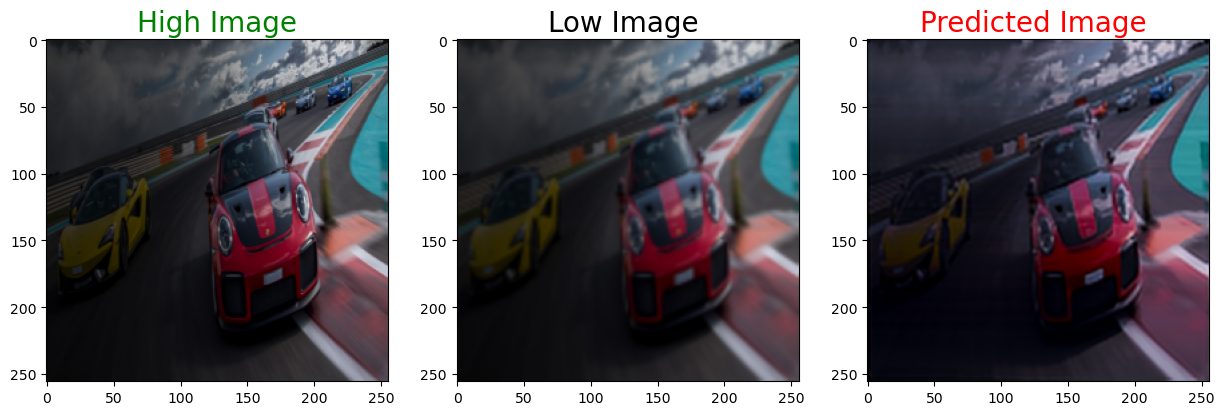

PSNR tf.Tensor(28.590736, shape=(), dtype=float32) dB


In [75]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(16,25):
    
    predicted = np.clip(Attention_based.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR',PSNR(test_high_image[i],predicted),'dB')